In [1]:
Packages <- c("broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "dplyr","tidyr", "stringr", "tidyverse", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") #median
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") #dist 90% retained
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernPDF.R")
#define my own cv function
cv <- function(x){
    sd(x)/mean(x)
}

In [2]:
#read in the kernel ensembles with survival and NoRecentRec adjustments
SimKernels2012 <- read.csv(file="~/oceanography/script_output/KernelFits/Adjust_Survival_NoRecentRecruits/1000SimulatedKernels2012SurvNoRecentRec.csv", header=T) %>%
    mutate(year=as.character(year)) %>%
    mutate(Adj="SurvNoRecentRec")
SimKernels2013 <- read.csv(file="~/oceanography/script_output/KernelFits/Adjust_Survival_NoRecentRecruits/1000SimulatedKernels2013SurvNoRecentRec.csv", header=T) %>%
    mutate(year=as.character(year)) %>%
    mutate(Adj="SurvNoRecentRec")
SimKernels2014 <- read.csv(file="~/oceanography/script_output/KernelFits/Adjust_Survival_NoRecentRecruits/1000SimulatedKernels2014SurvNoRecentRec.csv", header=T) %>%
    mutate(year=as.character(year)) %>%
    mutate(Adj="SurvNoRecentRec")
SimKernelsAll <- read.csv(file="~/oceanography/script_output/KernelFits/Adjust_Survival_NoRecentRecruits/1000SimulatedKernelsAllSurvNoRecentRec.csv", header=T) %>%
    mutate(year="2012-14") %>%
    mutate(Adj="SurvNoRecentRec")



CombinedSims <- bind_rows(SimKernels2012, SimKernels2013, SimKernels2014, SimKernelsAll)

#write.csv(CombinedSims, file="~/oceanography/script_output/KernelFits/CombinedSimulationKernelFitsOther0.1SurvNoRecentRec.csv", row.names=F)

In [25]:
CombinedSims <- fread(file="~/oceanography/script_output/KernelFits/CombinedSimulationKernelFitsOther0.1SurvNoRecentRec.csv", header=T, stringsAsFactors = F)
setnames(CombinedSims, "year", "Year")

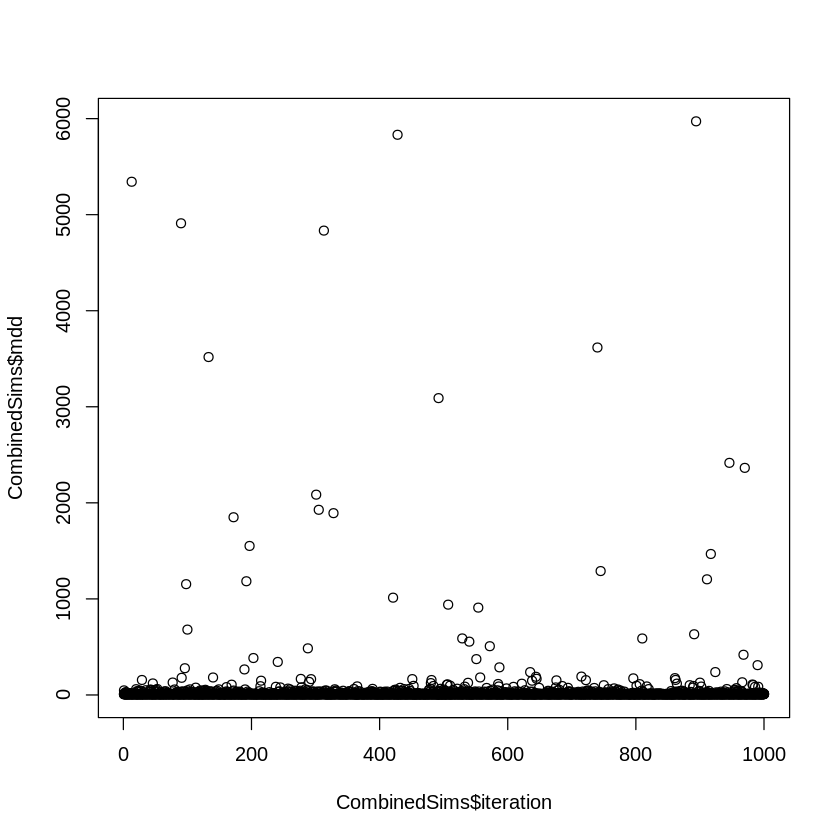

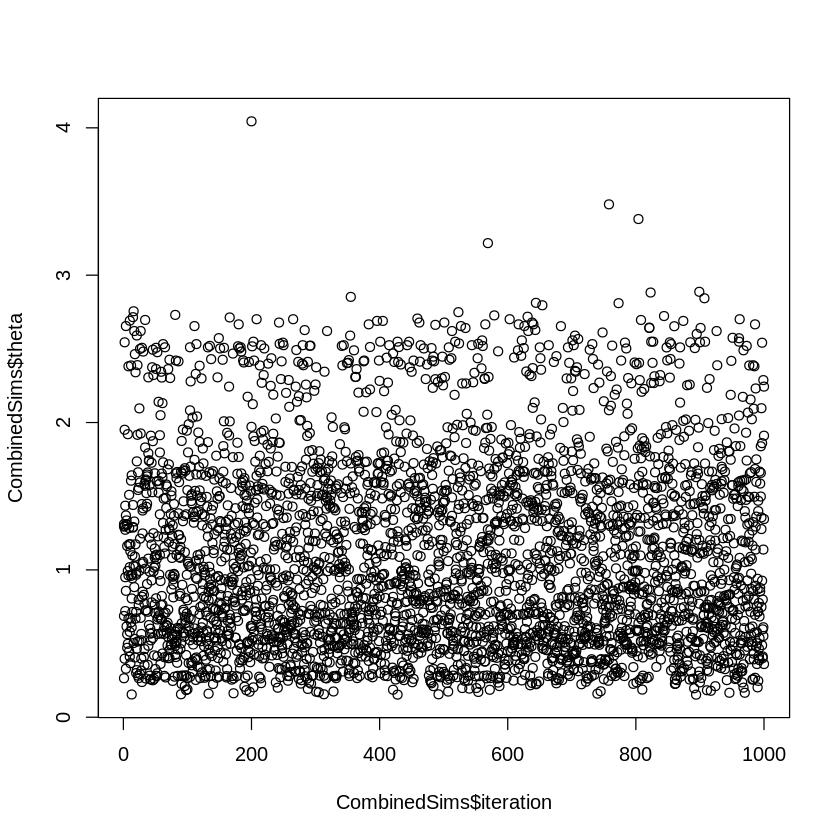

In [78]:
#check for obvious bias based on iteration, which would point to a problem in the for loop. Seems fine to me though 03/23/2021
plot(CombinedSims$mdd ~ CombinedSims$iteration)
plot(CombinedSims$theta ~ CombinedSims$iteration)

In [27]:
#how often do we see kernel fits that aren't great, as in the MLE is at the boundaries of our search
CombinedSims[k==10 |k==-10 | theta==0.15 |theta== 8, .N, by=c("Year")]


Year,N
2012,26
2014,344
2012-14,19


In [68]:
#what if we throw out the barrier fits
CombinedSims <- CombinedSims[k!=10 &k!=-10 & theta!=0.15 &theta!= 8]


In [69]:
#make a summary table with means
SimMean <- CombinedSims[, lapply(.SD, mean), by="Year", #apply the mean function to get means of each column by year
             .SDcols = -c("iteration", "Adj")] #but don't do that for iteration and adjustment column, not what we're interested in 
StatCol <- "Stat" #make the column to hold the Stat type
SimMean[,(StatCol):="mean"]      

SimMin <- CombinedSims[, lapply(.SD, min), by="Year", #apply the mean function to get means of each column by year
             .SDcols = -c("iteration", "Adj")]
SimMin[,(StatCol):="min"]   

SimMax <- CombinedSims[, lapply(.SD, max), by="Year", #apply the mean function to get means of each column by year
             .SDcols = -c("iteration", "Adj")]
SimMax[,(StatCol):="max"]  

SimCVWithin <- CombinedSims[, lapply(.SD, cv), by="Year", #apply the mean function to get means of each column by year
             .SDcols = -c("iteration", "Adj", "k")] #because k is negative sometimes we can't use CV
SimCVWithin[,(StatCol):="cv_within"]

#bind together all Stats into one data.table
Stats <- list(SimMean, SimMin, SimMax, SimCVWithin)
SimSummary <- rbindlist(Stats, use.names=TRUE, fill=TRUE)

#make new column to ID this as a table with summary of SIMULATED data

DataTypeCol <- "DataType" #make the column to hold data type
SimSummary[,(DataTypeCol):="Sim"]
#SimSummary <- melt(SimSummary, id.vars = c("Year", "DataType", "Stat"), #make into long format so each row is a variable mean in a year
#               measure.vars = c("k", "theta", "mdd", "med", "dist90"), variable.factor=F)
#write.csv(SimSummary, file="~/oceanography/script_output/KernelFits/SimulationKernelFitsSummary.csv", row.names=F)

In [70]:
head(SimSummary)

Year,k,theta,mdd,med,dist90,Stat,DataType
2012,-1.7484748,1.3719317,11.531482,6.515873,26.45164,mean,Sim
2013,-1.1316242,0.7660913,7.547451,4.289590,18.18786,mean,Sim
2014,-0.5779402,0.7847131,128.933721,19.695381,258.06297,mean,Sim
2012-14,-2.2652240,1.3500017,10.514526,6.965403,23.23198,mean,Sim
2012,-2.9853251,0.2366141,7.731419,4.940000,16.15000,min,Sim
2013,-2.7936518,0.2107426,5.414293,2.940000,12.80000,min,Sim


In [71]:
#read in the empirical data
kernels <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/kernel_fitting_summary.csv", header=T, stringsAsFactors = F)  %>%
    rename(k="best_k", theta="best_theta", mdd="MeanDispDist", med="MedianDispDist", dist90="Dist90Retained") %>%
    select(Year, k, theta, mdd, med, dist90) %>%
    mutate(DataType="Gen")

kernel2012_14 <- read.csv(file="~/oceanography/empirical_data/genetics/GenKernelsForROMSComp2012-14.csv", header=T, stringsAsFactors = F) %>%
    rename(Year="year")

kernels2 <- bind_rows(kernels, kernel2012_14) %>% 
    mutate(DataType="Gen") %>%
    filter(Year %in% c("2012", "2013", "2014", "2012-14")) %>% #exclude to only years matching the ROMS model for now
    mutate(Stat="MLE") %>%
    select(Year, DataType, Stat, everything()) #%>%
    #gather(4:9, key="variable", value="value")

kernels2$k <- round(kernels2$k, digits=2)
kernels2$theta <- round(kernels2$theta, digits=2)
kernels2$mdd <- round(kernels2$mdd, digits=2)

#or if long format
#kernels2$value <- round(kernels2$value, digits=2)

SimPlusGenFits <- rbindlist(list(SimSummary, kernels2), use.names=T)
#setDT(SimPlusGenFits)

#
#write.csv(SimPlusGenFits, file="~/oceanography/script_output/KernelFits/SimPlusGenKernelFits.csv", row.names=F)

In [72]:
SimPlusGenFits

Year,k,theta,mdd,med,dist90,Stat,DataType
2012,-1.7484748,1.3719317,11.5314819,6.5158727,2.645164e+01,mean,Sim
2013,-1.1316242,0.7660913,7.5474508,4.2895900,1.818786e+01,mean,Sim
2014,-0.5779402,0.7847131,128.9337209,19.6953811,2.580630e+02,mean,Sim
2012-14,-2.2652240,1.3500017,10.5145257,6.9654027,2.323198e+01,mean,Sim
2012,-2.9853251,0.2366141,7.7314189,4.9400000,1.615000e+01,min,Sim
2013,-2.7936518,0.2107426,5.4142931,2.9400000,1.280000e+01,min,Sim
2014,-3.0596260,0.1530688,8.1900066,5.6100000,1.663000e+01,min,Sim
2012-14,-3.0393345,0.1714102,2.9981540,1.7100000,7.350000e+00,min,Sim
2012,2.9244696,4.0441139,85.0449729,16.8700000,1.979800e+02,max,Sim
2013,4.3286081,1.8387354,93.4844552,15.1700000,2.072700e+02,max,Sim


In [75]:
#what's the amount of variation for mean, theta, and other variables across years in the simulations vs genetics? are we seeing the same magnitude of variability?
CompareCV <- SimPlusGenFits[Year !="2012-14" & Stat=="MLE" | Stat=="mean", #don't include the all- years estimates for this, isolate the mean values for the simulations
              lapply(.SD, cv), by="DataType",  
                .SDcols = -c("Year", "k", "Stat")]
CompareCV
CompareCV <- melt(CompareCV, id.vars = "DataType", 
         measure.vars = c("theta", "mdd", "med", "dist90"))

DataType,theta,mdd,med,dist90
Sim,0.3166867,1.502799,0.7456907,1.445305
Gen,0.7895541,1.043997,0.4202158,1.007820


Saving 6.67 x 6.67 in image


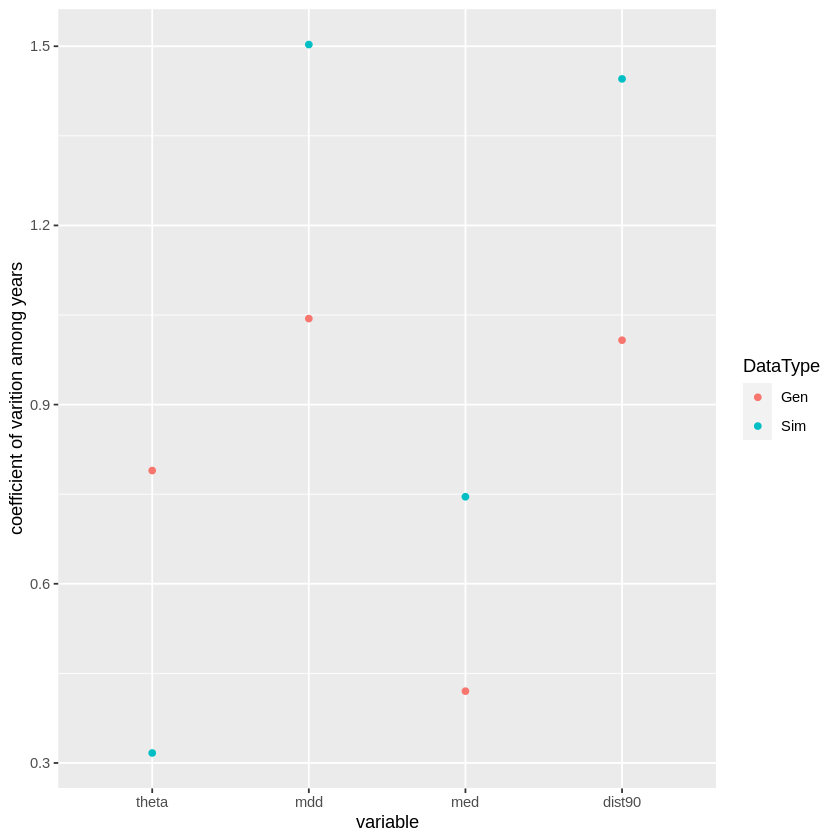

In [76]:
CVPlot <- ggplot(data=CompareCV, aes(x=variable, y=value, color=DataType)) +
    geom_point() +
    ylab("coefficient of varition among years") #+
   # ggtitle()
    #geom_point(aes(x=SimMDD, y=GenMDD), color="blue")
CVPlot
#ggsave(filename="SimulationGeneticFitsCVComparison.png", plot= CVPlot, path="~/oceanography/script_output/KernelFits/Plots/" )


In [ ]:
ggplot(data=SimKernelVar, aes(x=Adj, y=mdd, color=year, fill=year), alpha=0.5) +
    geom_point(data=SimPlusGenFits, aes(x=Year, y=AvgSimMDD, shape=Adj), fill=NA, color="black", size=3) + 
    geom_point(data=SimPlusGenFits, aes(x=Year, y=GenMDD), fill="red", color="red") + # with all fits


In [77]:
head(CombinedSims)
#head(SimPlusGenFits %>% spread(metric, value))

Year,k,theta,mdd,med,dist90,iteration,Adj
2012,2.263923,0.2645823,47.647397,11.23,114.86,1,SurvNoRecentRec
2012,-2.751382,2.5443994,8.185826,7.23,16.34,2,SurvNoRecentRec
2012,-2.396769,1.2721366,8.291947,6.25,18.34,3,SurvNoRecentRec
2012,-2.770307,2.6547136,8.260620,7.34,16.40,4,SurvNoRecentRec
2012,-2.433092,1.3359269,8.226354,6.30,18.05,5,SurvNoRecentRec
2012,-2.241767,1.1622086,7.788861,5.70,17.49,6,SurvNoRecentRec


Warning message:
“Removed 80 rows containing non-finite values (stat_ydensity).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 80 rows containing non-finite values (stat_ydensity).”

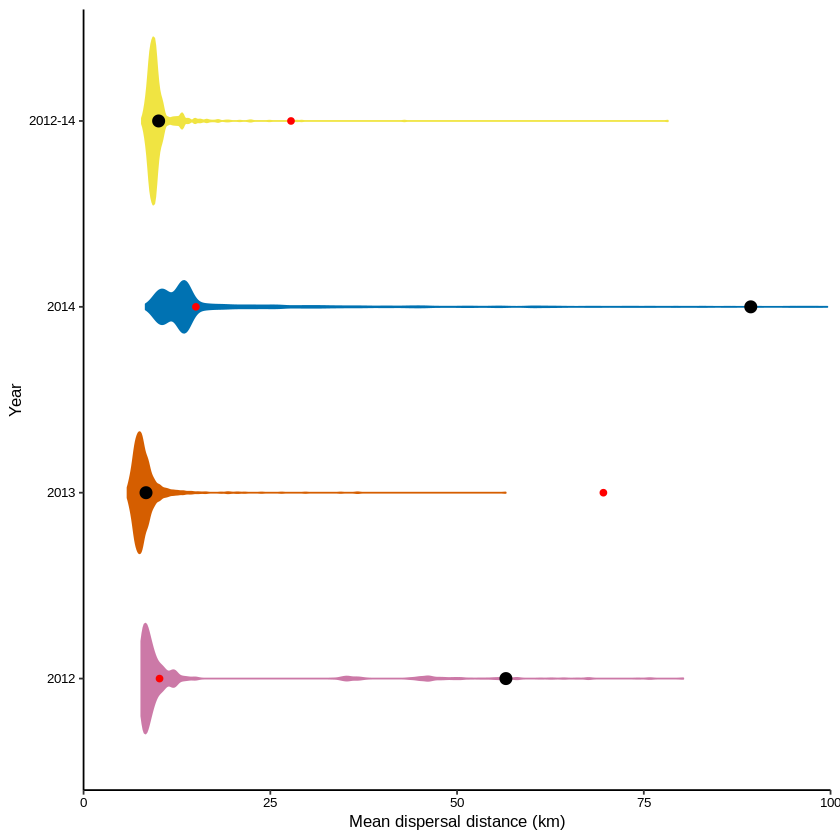

In [168]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

CombinedSims$Year <- factor(CombinedSims$Year, levels=c("2012", "2013", "2014", "2012-14"))
SimPlusGenFits$Year <- factor(SimPlusGenFits$Year, levels=c("2012", "2013", "2014", "2012-14"))
#PointsToPlot <- CompareFits %>% filter(Adj=="SurvNoRecentRec")
#PointsToPlot$Year <- factor(PointsToPlot$Year, levels=c("2012", "2013", "2014", "2012-14"))


mdd_violin <- ggplot(data=CombinedSims, aes(x=Year, y=mdd, color=Year, fill=Year), alpha=0.5) +
    geom_violin() +
    geom_point(data=PointsToPlot, aes(x=Year, y=SimMDD), fill=NA, color="black", size=3) + 
    geom_point(data=PointsToPlot, aes(x=Year, y=GenMDD), fill="red", color="red") + # with all fits
    #geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
    coord_flip() +
    scale_shape_discrete(name = "Adjustment", labels = c("only >3.5 cm", "none", "only >3.5 cm and survival weighting"))+
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 100), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica")) + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev) +
    theme(legend.position = "none") 
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin 
ggplot2::ggsave(filename="SimMeanDispDistPlusGenPointsSurvNoRecentRec.png",  plot=mdd_violin, path="~/oceanography/script_output/KernelFits/Plots/")


Warning message:
“Removed 344 rows containing non-finite values (stat_ydensity).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 344 rows containing non-finite values (stat_ydensity).”

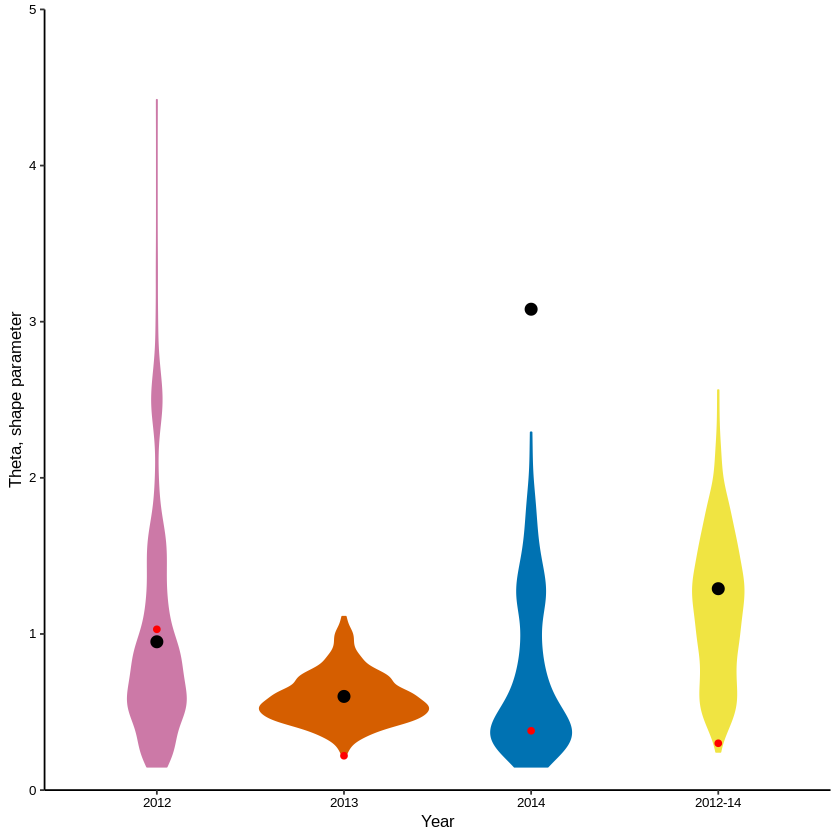

In [167]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

CombinedSims$year <- factor(CombinedSims$year, levels=c("2012", "2013", "2014", "2012-14"))
SimPlusGenFits$Year <- factor(SimPlusGenFits$Year, levels=c("2012", "2013", "2014", "2012-14"))
PointsToPlot <- CompareFits %>% filter(Adj=="SurvNoRecentRec")
PointsToPlot$Year <- factor(PointsToPlot$Year, levels=c("2012", "2013", "2014", "2012-14"))


theta_violin <- ggplot(data=CombinedSims %>% filter(Adj=="SurvNoRecentRec"), aes(x=year, y=theta, color=year, fill=year), alpha=0.5) +
    geom_violin() +
    geom_point(data=PointsToPlot, aes(x=Year, y=SimTheta), fill=NA, color="black", size=3) + 
    geom_point(data=PointsToPlot, aes(x=Year, y=GenTheta), fill="red", color="red") + # with all fits
    #geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
   # coord_flip() +
    scale_shape_discrete(name = "Adjustment", labels = c("only >3.5 cm", "none", "only >3.5 cm and survival weighting"))+
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 5), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Theta, shape parameter") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica")) + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev) +
    theme(legend.position = "none") 
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
theta_violin 
ggplot2::ggsave(filename="SimThetaPlusGenPointsSurvNoRecentRec.png",  plot=theta_violin, path="~/oceanography/script_output/KernelFits/Plots/")


In [154]:
str(PointsToPlot)

tibble [4 × 14] (S3: grouped_df/tbl_df/tbl/data.frame)
 $ Year            : Factor w/ 4 levels "2012","2013",..: 1 4 2 3
 $ GenDist90       : num [1:4] 23.3 68.7 157.4 38.1
 $ GenK            : num [1:4] -2.36 1.68 4.04 0.49
 $ GenMDD          : num [1:4] 10.2 27.8 69.6 15
 $ GenMed          : num [1:4] 7.13 7.71 12.2 5.53
 $ GenTheta        : num [1:4] 1.03 0.3 0.22 0.38
 $ Adj             : chr [1:4] "SurvNoRecentRec" "SurvNoRecentRec" "SurvNoRecentRec" "SurvNoRecentRec"
 $ SimDist90       : num [1:4] 107.2 22.9 20.7 173.1
 $ SimK            : num [1:4] -1.11 -2.14 -0.61 -1.61
 $ SimMDD          : num [1:4] 56.54 10.05 8.36 89.32
 $ SimMed          : num [1:4] 9.67 6.86 4.14 16.66
 $ SimTheta        : num [1:4] 0.95 1.29 0.6 3.08
 $ MDDDiffGenVSim  : num [1:4] 46.4 17.7 61.2 74.3
 $ ThetaDiffGenVSim: num [1:4] 0.08 0.99 0.38 2.7
 - attr(*, "groups")= tibble [4 × 2] (S3: tbl_df/tbl/data.frame)
  ..$ Year : Factor w/ 4 levels "2012","2013",..: 1 2 3 4
  ..$ .rows: list<int> [1:4] 
  ..

In [161]:
#read in the seasonal simulation kernel fits

#no adjustments
SimulatedKernelsNEM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEM.csv", header=T) %>%
    mutate(Adj="no")
SimulatedKernelsSWM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWM.csv", header=T) %>%
    mutate(Adj="no")

#adjusting for survival and growth
SimulatedKernelsNEMSurvGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEMSurvGrowth.csv", header=T) %>%
    mutate(Adj="SurvGrowth")
SimulatedKernelsSWMSurvGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWMSurvGrowth.csv", header=T) %>%
    mutate(Adj="SurvGrowth")

#adjusting for growth
SimulatedKernelsNEMGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEMGrowth.csv", header=T) %>%
    mutate(Adj="Growth")
SimulatedKernelsSWMGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWMGrowth.csv", header=T) %>%
    mutate(Adj="Growth")

CombinedSeasons <- bind_rows(SimulatedKernelsNEM, SimulatedKernelsSWM, SimulatedKernelsNEMSurvGrowth, SimulatedKernelsSWMSurvGrowth, SimulatedKernelsNEMGrowth, SimulatedKernelsSWMGrowth) %>%
    rename(Season="season") 

#empirical seasons for 2012-2014
SeasonalKernels2012_14 <- read.csv(file="~/oceanography/empirical_data/genetics/SeasonalGenKernelsForROMSComp.csv", header=T) %>%
    rename(Season="season",GenK="k", GenTheta="theta", GenMDD="mdd", GenMed="med", GenDist90="dist90") %>%
    mutate(GenK=round(GenK, digits=2)) %>%
    mutate(GenTheta=round(GenTheta, digits=2)) %>%
    mutate(GenMDD=round(GenMDD, digits=2)) %>%
    mutate(TimeFrame="2012-14")#%>%
    #mutate(JoinKey="all")


SeasonalKernels2012_18 <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv", header=T) %>%
    select(Season, best_k, best_theta, MeanDispersalDistance, MedianDispersalDistance, Dist90Retained) %>%    
    rename(GenK="best_k", GenTheta="best_theta", GenMDD="MeanDispersalDistance", GenMed="MedianDispersalDistance", GenDist90="Dist90Retained") %>%
    mutate(GenMDD=round(GenMDD, digits=2)) %>%
    mutate(TimeFrame="2012-18")#%>%
    #mutate(JoinKey="all")

GenSeasonalKernels <- bind_rows(SeasonalKernels2012_14, SeasonalKernels2012_18)

In [151]:
head(CombinedSeasons)

Season,k,theta,mdd,med,dist90,iteration,Adj
NEM,-2.49,1.30,8.94,6.78,19.71,1,no
NEM,0.85,0.34,21.84,7.14,55.00,2,no
NEM,-1.38,0.64,10.05,5.59,24.73,3,no
NEM,-2.06,0.91,9.06,6.05,21.17,4,no
NEM,-2.52,1.33,9.04,6.91,19.86,5,no
NEM,-1.92,0.84,9.04,5.82,21.40,6,no


In [162]:
AvgSeasonalKernels <- CombinedSeasons %>% 
    select(-iteration) %>%
    group_by(Season, Adj) %>%
    summarise_each(funs(mean)) %>%
    mutate(k=round(k, digits=2)) %>%
    mutate(theta=round(theta, digits=2)) %>%
    mutate(mdd=round(mdd, digits=2))%>%
    mutate(med=round(med, digits=2))%>%
    mutate(dist90=round(dist90, digits=2)) %>%
    rename(AvgSimK="k", AvgSimTheta="theta", AvgSimMDD="mdd", AvgSimMed="med", AvgSimDist90="dist90") %>%
    mutate(TimeFrame="2012-14")# %>%
    #mutate(JoinKey="all")

In [189]:
SimPlusGenFitsSeasons <- right_join(AvgSeasonalKernels, GenSeasonalKernels, by=c("Season", "TimeFrame"))%>%
    mutate(MDDDiffGenVSim=abs(GenMDD-AvgSimMDD)) %>%
    arrange(MDDDiffGenVSim) %>%
    mutate(GenK=round(GenK, digits=2)) %>%
    mutate(GenTheta=round(GenTheta, digits=2)) %>%
    mutate(GenMDD=round(GenMDD, digits=2))

SimPlusGenFitsSeasons %>%
    group_by(Season) %>%
    filter(MDDDiffGenVSim==min(MDDDiffGenVSim, na.rm=T))

SimPlusGenFitsSeasons

#write.csv(SimPlusGenFits, file="~/oceanography/script_output/KernelFits/SimPlusGenKernelFitsSeasons.csv", row.names=F)

Season,Adj,AvgSimK,AvgSimTheta,AvgSimMDD,AvgSimMed,AvgSimDist90,TimeFrame,GenK,GenTheta,GenMDD,GenMed,GenDist90,MDDDiffGenVSim
SWM,no,-2.45,1.39,8.58,6.57,18.77,2012-14,-1.62,0.76,8.34,5.1,20.07,0.24
NEM,SurvGrowth,-2.02,1.17,10.10,6.69,23.37,2012-14,6.95,0.15,2755.86,212.8,4810.04,2745.76


Season,Adj,AvgSimK,AvgSimTheta,AvgSimMDD,AvgSimMed,AvgSimDist90,TimeFrame,GenK,GenTheta,GenMDD,GenMed,GenDist90,MDDDiffGenVSim
SWM,no,-2.45,1.39,8.58,6.57,18.77,2012-14,-1.62,0.76,8.34,5.10,20.07,0.24
SWM,SurvGrowth,-2.44,1.37,8.63,6.59,18.94,2012-14,-1.62,0.76,8.34,5.10,20.07,0.29
SWM,Growth,-2.40,1.32,8.66,6.52,19.13,2012-14,-1.62,0.76,8.34,5.10,20.07,0.32
NEM,SurvGrowth,-2.02,1.17,10.10,6.69,23.37,2012-14,6.95,0.15,2755.86,212.80,4810.04,2745.76
NEM,Growth,-2.04,1.17,10.01,6.66,23.13,2012-14,6.95,0.15,2755.86,212.80,4810.04,2745.85
NEM,no,-2.08,1.26,9.95,6.72,22.82,2012-14,6.95,0.15,2755.86,212.80,4810.04,2745.91
SWM,NA,NA,NA,NA,NA,NA,2012-18,-2.60,1.58,8.57,6.87,18.32,NA
NEM,NA,NA,NA,NA,NA,NA,2012-18,-0.89,0.56,9.45,4.82,23.60,NA


Warning message:
“Removed 2 rows containing missing values (geom_point).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

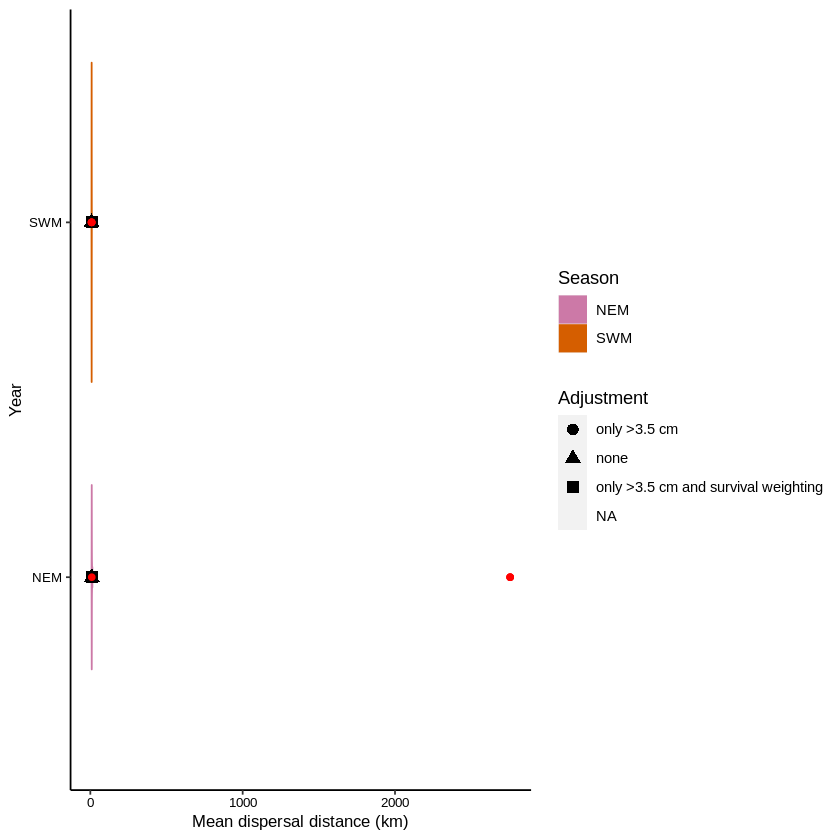

In [193]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

#CombinedSeasons$Season <- factor(CombinedSeasons$Season, levels=c("2012", "2013", "2014", "2012-14"))
#SimPlusGenFitsSeasons$Season <- factor(SimPlusGenFitsSeasons$Season, levels=c("2012", "2013", "2014", "2012-14"))

mdd_violin <- ggplot(data=CombinedSeasons, aes(x=Season, y=mdd, color=Season, fill=Season), alpha=0.5) +
    geom_violin() +
    geom_point(data=SimPlusGenFitsSeasons, aes(x=Season, y=AvgSimMDD, shape=Adj), fill=NA, color="black", size=3) + 
    geom_point(data=SimPlusGenFitsSeasons, aes(x=Season, y=GenMDD), fill="red", color="red") + # with all fits
    #geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
    coord_flip() +
    scale_shape_discrete(name = "Adjustment", labels = c("only >3.5 cm", "none", "only >3.5 cm and survival weighting"))+
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    #scale_y_continuous(limits = c(0, 30), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica")) + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin
ggplot2::ggsave(filename="SimMeanDispDistPlusGenPointsSeasons.png",  plot=mdd_violin, path="~/oceanography/script_output/KernelFits/Plots/")


In [192]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

mdd_violin <- ggplot(data=SimCombinedSummary, aes(x=year, y=mdd, color=year, fill=year), alpha=0.5) +
    geom_violin() +
    #geom_point(data=AverageFits2, aes(x=year, y=mdd), fill="snow",color="darkgray", shape=21) + #without borderline fits
    geom_point(data=AverageFits, aes(x=year, y=mdd), fill="black ",color="darkgray", shape=21) + # with all fits
    geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
    coord_flip() +
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 83), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica"),    
    legend.position = "none") + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin
ggplot2::ggsave(filename="SimMeanDispDistPlusGenPoints.png",  plot=mdd_violin, path="~/oceanography/script_output/KernelFits/Plots/")


ERROR: Error in ggplot(data = SimCombinedSummary, aes(x = year, y = mdd, color = year, : object 'SimCombinedSummary' not found


In [115]:
(SimPlusGenFits)

year,SimK,SimTheta,SimMDD,SimKurtosis,GenK,GenTheta,GenMDD,GenMedDispDist
2012,-1.828326,1.250510,10.127328,15.518027,-2.36,1.03,10.165094,7.13
2013,-1.242150,0.804757,8.091848,13.967938,4.04,0.22,69.586280,12.20
2014,-1.926596,1.243059,26.376964,86.415760,0.49,0.38,15.037515,5.53
all,-1.919426,1.014670,10.219857,8.635482,-2.51,1.49,8.153016,6.44


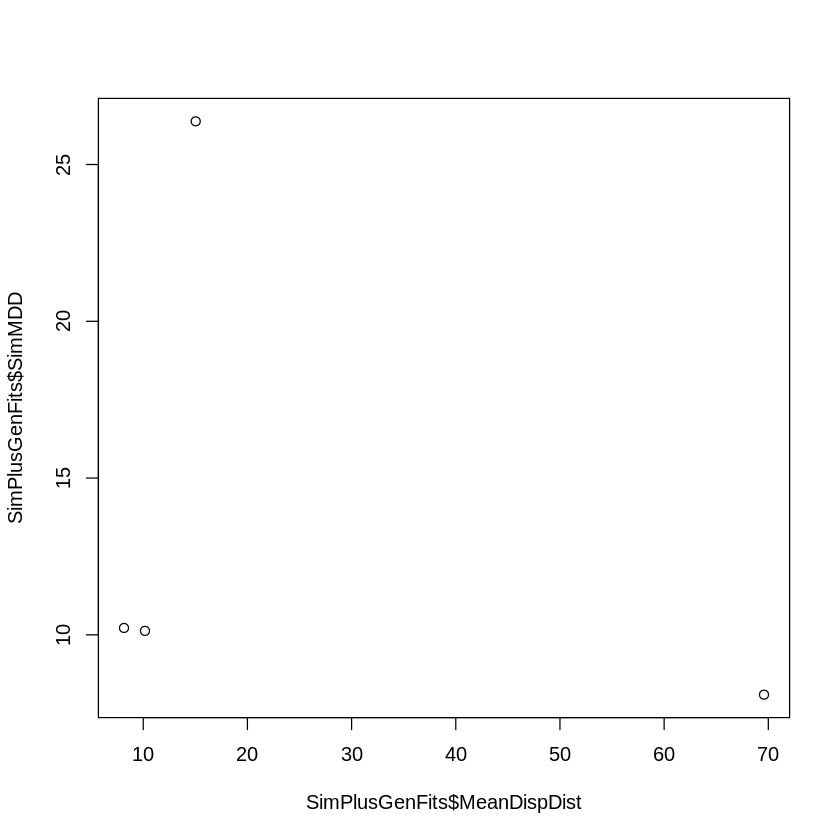

In [95]:
plot(SimPlusGenFits$SimMDD~SimPlusGenFits$MeanDispDist)

In [60]:
MDDAllYear <- CombinedSims %>% 
    filter(year=="all")
#pdf("~/oceanography/script_output/KernelFits/Plots/MeanDispDistHist2012-14.pdf")
hist(MDDAllYear$mdd, breaks=100, main=NULL, xlab="Mean dispersal distance (km)")
#dev.off()
summary(MDDAllYear$mdd)

Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in hist.default(MDDAllYear$mdd, breaks = 100, main = NULL, xlab = "Mean dispersal distance (km)"): character(0)


In [97]:
#test for correlations
cor.test(SimPlusGenFits$SimMDD, SimPlusGenFits$MeanDispDist,  method = "pearson")
cor.test(SimPlusGenFits$SimTheta, SimPlusGenFits$GenTheta,  method = "pearson")



	Pearson's product-moment correlation

data:  SimPlusGenFits$SimMDD and SimPlusGenFits$MeanDispDist
t = -0.53384, df = 2, p-value = 0.6468
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9812079  0.9202897
sample estimates:
       cor 
-0.3531582 



	Pearson's product-moment correlation

data:  SimPlusGenFits$SimTheta and SimPlusGenFits$GenTheta
t = 0.32913, df = 2, p-value = 0.7733
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9389710  0.9752907
sample estimates:
      cor 
0.2266754 


In [17]:
#seasons
SimulatedKernelsNEM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEM.csv", header=T)
SimulatedKernelsSWM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWM.csv", header=T)
CombinedSeasons <- bind_rows(SimulatedKernelsNEM, SimulatedKernelsSWM) %>%
    select(-iteration)

In [24]:
SeasonalKernels <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv", header=T)
head(SeasonalKernels)

Season,RecruitSizeAtSampling,best_k,best_theta,k_CI95_lower,k_CI95_upper,theta_CI95_lower,theta_CI95_upper,MeanDispersalDistance,MeanDispDist_CI95_lower,MeanDispDist_CI95_upper,MedianDispersalDistance,MedianDispDist_CI95_lower,MedianDispDist_CI95_upper,Dist90Retained
SWM,> 4.5 cm,-2.60,1.58,-2.63,-2.47,1.34,1.59,8.574871,7.132250,10.39623,6.87,4.93,9.28,18.32
NEM,< 3.5 cm,-0.89,0.56,-1.46,-0.74,0.54,0.61,9.446898,6.014163,4272.46841,4.82,3.24,323.37,23.60
